In [1]:
# Module import

from __future__ import print_function

from IPython.display import Image
import sys
import pandas as pd

# To use interact -- IPython widget
#
#from ipywidgets import interact, interactive, fixed, interact_manual
#import ipywidgets as widgets


# append to path the folder that contains the analytic scanner
sys.path.append('../GaiaLab/scan/analytic_scanner')
# local imports
#from gaia_analytic_toymodel import *

from scipy import interpolate
import timeit

import frame_transformations as ft
from scanner import Scanner
from satellite import Satellite
from source import Source

import constants as const

from quaternion import Quaternion
from agis import Agis
from agis import Calc_source
from agis_functions import *

from analytic_plots import *

import astropy.units as u
import time

from scipy import sparse as sps

# Ipython magics
%load_ext autoreload
%autoreload 2
%matplotlib notebook 
# %matplotlib widget
# %matplotlib ipympl
%reload_ext autoreload


# For scaling: 


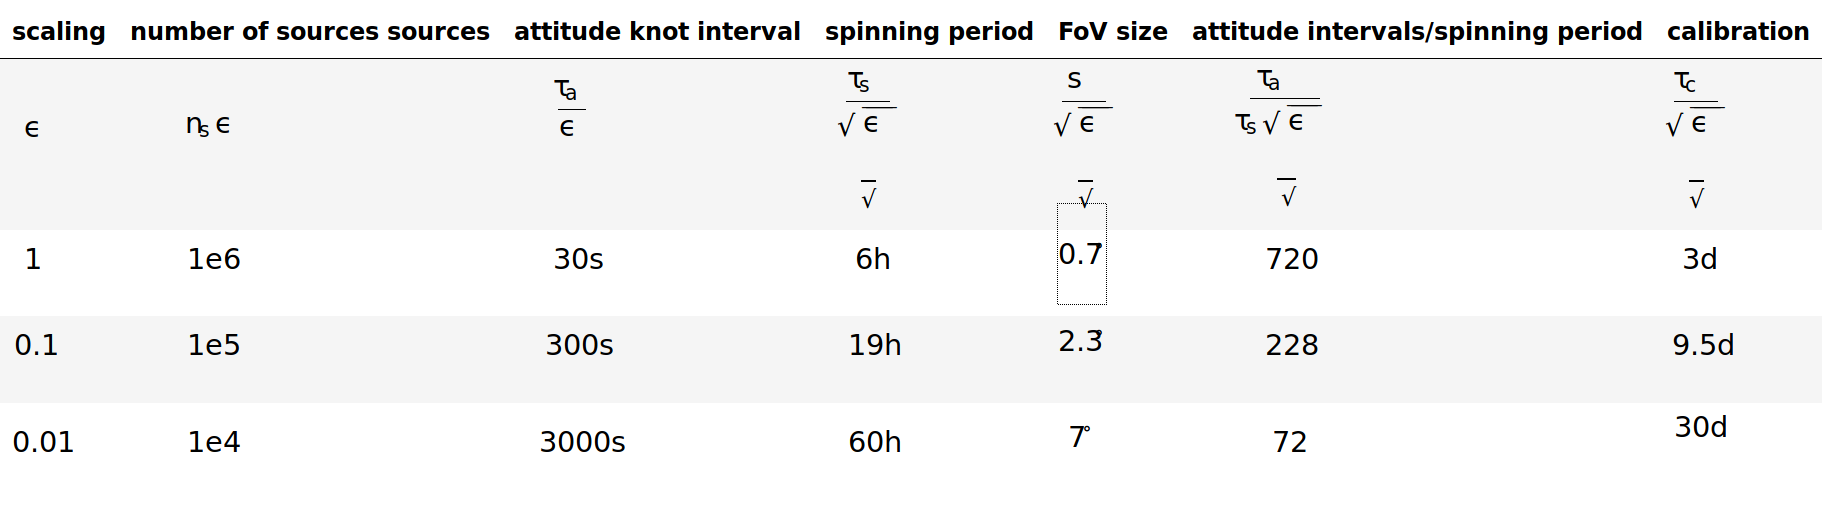

In [2]:
Image('./figures/scaling_factors.png')

# **Initializing objects:**

In [3]:
# # create all the objects we will need:
# parameters for the notebook
t_init = 0 
t_end =  t_init + 1/2
my_dt = 1/24/2 # [days]

# objects
spline_degree = 3

gaia = Satellite(ti=t_init, tf=t_end, dt= my_dt, k=spline_degree)
print('Sat created')

Sat created


In [4]:
double_telescope = True
my_scanner = Scanner(zeta_limit=np.radians(5) ,double_telescope=double_telescope) 
print('Scanner created')

num_sources=300  # has to be divisible by 3

Scanner created


# End scanner

In [57]:
# Functions usefull for this bit:
times_for_source = np.linspace(t_init, t_end, num=num_sources//3, endpoint=True)

def generate_angles_of_sources():
    # Warning be carefull to what you use to get alpha/delta from vector
    alphas, deltas = ([], [])
    for t in times_for_source:
        noise = np.random.rand(6) *0
        attitude = gaia.func_attitude(t)
        alpha, delta = generate_observation_wrt_attitude(attitude)
        a_P, d_P, a_F, d_F = get_angular_FFoV_PFoV(gaia, t)
        alphas += [alpha +noise[0], a_P+noise[1], a_F+noise[2]]
        deltas += [delta +noise[3], d_P+noise[4], d_F+noise[5]]
    return alphas, deltas


In [58]:
def generate_telescope_positions(num_points = 10000):
    # Generate telescopes positions
    alphas_P, deltas_P, alphas_F, deltas_F = ([], [], [], [])
    for t in np.linspace(t_init, t_end, num=num_points):
        a_P, d_P, a_F, d_F = get_angular_FFoV_PFoV(gaia, t)
        alphas_P.append(a_P-np.pi)
        deltas_P.append(d_P)
        alphas_F.append(a_F-np.pi)
        deltas_F.append(d_F)
    return alphas_P, deltas_P, alphas_F, deltas_F

In [59]:
def transform_twoPi_into_halfPi(deltas):
    deltas = np.array(deltas)
    up_indices = np.where(deltas>np.pi)[0]
    down_indices = np.where(deltas<np.pi)[0]
    deltas[up_indices] -= 2*np.pi
    # deltas[down_indices] += np.pi
    return deltas
    

In [60]:
def add_nans(x,y):
    pos = np.where(np.abs(np.diff(x)) >= 2)[0]+1
    x = np.insert(x, pos, np.nan)
    y = np.insert(y, pos, np.nan)
    """pos = np.where(np.abs(np.diff(y)) >= 1)[0]+1
    x = np.insert(x, pos, np.nan)
    y = np.insert(y, pos, np.nan)"""
    return x, y

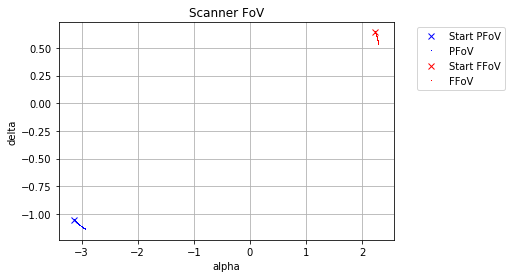

Plotted first plot


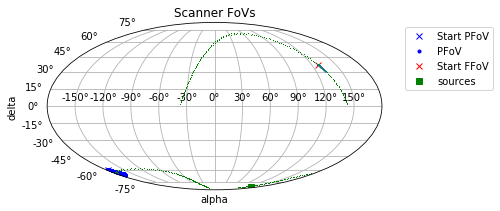

In [61]:
a_min, a_max = (0,100)
alphas, deltas = generate_angles_of_sources()
alphas_P, deltas_P, alphas_F, deltas_F = generate_telescope_positions()

deltas_P = transform_twoPi_into_halfPi(deltas_P)
deltas_F = transform_twoPi_into_halfPi(deltas_F)
fig = plt.figure()
#plt.plot(aplhas[0], deltas[0], 's')
plt.plot(alphas_P[0], deltas_P[0], 'bx', label='Start PFoV')
plt.plot(alphas_P[a_min : a_max], deltas_P[a_min : a_max], 'b,', label='PFoV')
plt.plot(alphas_F[0], deltas_F[0], 'rx', label='Start FFoV')
plt.plot(alphas_F[a_min : a_max], deltas_F[a_min : a_max], 'r,', label='FFoV')

"""plt.plot(alphas[0]-np.pi, deltas[0], 'gs', label='sources')
for a,d in zip(alphas[1:], deltas[1:]):
    plt.plot(a-np.pi, d, 'gs')"""

plt.title("Scanner FoV")
plt.legend(loc=9, bbox_to_anchor=(1.2, 1))
plt.grid(True), plt.xlabel('alpha'), plt.ylabel('delta')
plt.show()

print('Plotted first plot')
# ------------------------------ Separation  ----------------------------------------------

fig = plt.figure()
plt.subplot(111, projection="mollweide")
#plt.plot(aplhas[0], deltas[0], 's')
plt.plot(alphas_P[0], deltas_P[0], 'bx', label='Start PFoV')
plt.plot(alphas_P[a_min : a_max], deltas_P[a_min : a_max], 'b.', label='PFoV', alpha=1, linestyle="None", linewidth=0)
plt.plot(alphas_F[0], deltas_F[0], 'rx', label='Start FFoV', linestyle="None")
# plt.scatter(alphas_F[a_min : a_max], deltas_F[a_min : a_max], marker='.')
plt.plot(alphas_F[a_min : a_max], deltas_F[a_min : a_max], marker=',')

plt.plot(alphas[0]-np.pi, deltas[0], 'gs', label='sources')
for a,d in zip(alphas[1:], deltas[1:]):
    plt.plot(a-np.pi, d, 'g,')

plt.title("Scanner FoVs")
plt.legend(loc=9, bbox_to_anchor=(1.2, 1))
plt.grid(True), plt.xlabel('alpha'), plt.ylabel('delta')
plt.show()
fig.savefig('./figures/tmp/Mollweide_scanner_positions')

In [62]:
# create soures from that: 
sources = []
for n in range(num_sources):
    sources.append(Source(str(n), np.degrees(alphas[n]), np.degrees(deltas[n]), 10, 10, 10, 10))
    # sources.append(Source(str(n), alphas[n], deltas[n], parallaxes[n], mu_alphas[n], mu_deltas[n], mu_radials[n]))
print('Sources created')

Sources created


# **Scan**

In [63]:
obs_times = []
calc_sources = []
real_sources = []
for s in sources:
    my_scanner.scan(gaia, s, ti=t_init, tf=t_end)
    my_scanner.compute_angles_eta_zeta(gaia, s)
    print('zetas:', my_scanner.zeta_scanned)
    print('etas:', my_scanner.eta_scanned)
    print('times:', my_scanner.obs_times)
    print('How many observation time?  {}'.format(len(my_scanner.obs_times)))
    if len(my_scanner.obs_times)>0:
        obs_times += my_scanner.obs_times
        print('Error: ', my_scanner.scanner_error())
        real_sources.append(s)
        calc_sources.append(Calc_source(obs_times=my_scanner.obs_times.copy(), source=s))
    print('------------------------------------------------------')
sources = real_sources
obs_times = list(np.sort(obs_times))

Starting scan with time from 0 to 0.5 days
Total measured time: 0.017110586166381836
zetas: [-0.0015200864457320558, -0.0038852340447772193, -0.005697281256196643, -0.00791960307296718]
etas: [1.1102230246251565e-16, -5.551115123125783e-16, 5.551115123125783e-16, 3.3306690738754696e-16]
times: [0.03697882922704204, 0.21301945932240207, 0.2869772128260399, 0.46301551149053377]
How many observation time?  4
Error:  1.1102230246251565e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.024868011474609375
zetas: [-2.5560028163451598e-08, -0.005346730298787905, -0.016025847725699247, -0.02134872229606199, -0.03196928623799277]
etas: [0.0, 2.220446049250313e-16, -3.3306690738754696e-16, 1.1102230246251565e-16, -5.551115123125783e-16]
times: [1.1606912820027583e-09, 0.07395845485590774, 0.2499976288411218, 0.32395639353978684, 0.49999080307103827]
How many observation time?  5
Error:  -1.1102230246251565e-16
------------

Total measured time: 0.025552749633789062
zetas: [0.002163829359050084, -0.0033342756889822326, -0.014379475692659424, -0.019858593198256166]
etas: [0.0, 2.220446049250313e-16, 0.0, -1.1102230246251565e-16]
times: [0.0034232494751946984, 0.07738336857052408, 0.253423532206441, 0.32738244912483677]
How many observation time?  4
Error:  2.7755575615628914e-17
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.015159845352172852
zetas: [-2.5523159599694093e-08, -0.00477820686729604, -0.014175245816698238, -0.018988754941462037]
etas: [-1.1102230246251565e-16, -1.1102230246251565e-16, 1.1102230246251565e-16, 1.1102230246251565e-16]
times: [0.040404041755435674, 0.11436337299000476, 0.2904075750456349, 0.3643698144730044]
How many observation time?  4
Error:  0.0
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.014729499816894531
zetas: [-2.5479213350

Total measured time: 0.014647483825683594
zetas: [-2.5438691070300837e-08, -0.001566976926154995, -0.0033483627921101974, -0.004975353628381912]
etas: [0.0, -2.220446049250313e-16, -4.440892098500626e-16, -2.220446049250313e-16]
times: [0.07070707132301361, 0.1446661195928021, 0.3207096907959102, 0.39466960638476595]
How many observation time?  4
Error:  -2.220446049250313e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.029147624969482422
zetas: [-2.553510836111883e-08, -0.010254976911516783, -0.015397261692297116, -0.025581460996109195]
etas: [-3.3306690738754696e-16, 2.220446049250313e-16, 3.3306690738754696e-16, 1.1102230246251565e-16]
times: [0.07070707179281359, 0.24674746400014297, 0.3207060882758144, 0.49674307300724657]
How many observation time?  4
Error:  8.326672684688674e-17
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.0155

Total measured time: 0.01337575912475586
zetas: [0.0046389015445699655, -2.553207378852563e-08, -0.0090685608916053, -0.013745206918629228]
etas: [-1.1102230246251565e-16, -2.220446049250313e-16, -4.440892098500626e-16, -7.771561172376096e-16]
times: [0.04220349072386782, 0.11616161749249602, 0.29220506822602155, 0.36616622392830883]
How many observation time?  4
Error:  -3.885780586188048e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.013367176055908203
zetas: [-0.0006726994533683171, -0.0005036693251825922, 0.0018445228142306728, 0.001952644546126317]
etas: [2.220446049250313e-16, -1.1102230246251565e-16, -3.3306690738754696e-16, -6.661338147750939e-16]
times: [0.08423273996358956, 0.15819158934279173, 0.3342339118943054, 0.40819199316094695]
How many observation time?  4
Error:  -2.220446049250313e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total me

Total measured time: 0.013519763946533203
zetas: [-2.55359879353101e-08, 0.0035053749545076104, 0.013912676320152001, 0.01745639732855736]
etas: [1.1102230246251565e-16, 2.220446049250313e-16, 6.661338147750939e-16, 4.440892098500626e-16]
times: [0.16666666532743887, 0.24062513353910644, 0.4166702729578344, 0.4906307312509656]
How many observation time?  4
Error:  3.608224830031759e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.015562772750854492
zetas: [-0.0012238752112764082, -2.546378240209091e-08, 0.0048643294305172535, 0.006030310475221205]
etas: [1.1102230246251565e-16, -3.3306690738754696e-16, 9.992007221626409e-16, 1.1102230246251565e-16]
times: [0.09270782792392586, 0.16666666651037518, 0.3427082794697899, 0.41666543707987336]
How many observation time?  4
Error:  2.220446049250313e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured tim

Total measured time: 0.013357162475585938
zetas: [-0.005630155501896274, -0.0011217622483441797, -4.610673156937509e-05, 0.004603062521253296]
etas: [0.0, 1.1102230246251565e-16, -4.440892098500626e-16, -1.1102230246251565e-16]
times: [0.014253138293010368, 0.19029367197886327, 0.26425187793581445, 0.4402948505629172]
How many observation time?  4
Error:  -1.1102230246251565e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.013603687286376953
zetas: [0.006332783204636417, -2.5496392816459764e-08, -0.0034835696186721293, -0.009694627715823452]
etas: [2.220446049250313e-16, 4.440892098500626e-16, 1.1102230246251565e-16, -1.1102230246251565e-16]
times: [0.0512297029645189, 0.22727272776474886, 0.30123112172145317, 0.477269630561872]
How many observation time?  4
Error:  1.6653345369377348e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.013

Total measured time: 0.01299905776977539
zetas: [0.00698581084664008, 0.0010698538015505522, -0.002237801213783104, -0.008029118921818856]
etas: [0.0, 0.0, 5.551115123125783e-16, 6.661338147750939e-16]
times: [0.04960361514687524, 0.2256470434542424, 0.29960557678159633, 0.4756447475577859]
How many observation time?  4
Error:  3.0531133177191805e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.017051219940185547
zetas: [0.01732058438277696, 0.011597851087390488, -2.554667681792331e-08, -0.005718032681448738]
etas: [0.0, 3.3306690738754696e-16, -3.3306690738754696e-16, 1.1102230246251565e-16]
times: [0.012624899334566732, 0.08658345617501188, 0.2626262639948003, 0.33658520893976274]
How many observation time?  4
Error:  2.7755575615628914e-17
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.013997554779052734
zetas: [-0.006249766027370415, 

Total measured time: 0.015094518661499023
zetas: [0.01202153449250292, 0.007883616729461328, -2.5522869651073428e-08, -0.0041826541740990235]
etas: [1.1102230246251565e-16, 4.440892098500626e-16, -8.881784197001252e-16, 6.661338147750939e-16]
times: [0.04798224659571457, 0.12193817771317543, 0.29797979921755774, 0.3719388993243272]
How many observation time?  4
Error:  8.326672684688674e-17
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.01416158676147461
zetas: [0.008615330045520031, 0.003127181665829367, -2.546185645657673e-08, -0.005360979957711635]
etas: [1.1102230246251565e-16, 0.0, 2.220446049250313e-16, 0.0]
times: [0.047976658336667484, 0.22402106025426166, 0.29797979835620486, 0.47402022573704067]
How many observation time?  4
Error:  8.326672684688674e-17
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.018314838409423828
zetas: [0.0

How many observation time?  4
Error:  0.0
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.013432025909423828
zetas: [0.02258766785680209, 0.01697683932670281, 0.005624184846100295, -2.5548323290269795e-08]
etas: [1.1102230246251565e-16, 0.0, -2.220446049250313e-16, -3.3306690738754696e-16]
times: [0.024528502957691264, 0.098484415419312, 0.27452671862321176, 0.3484848499372767]
How many observation time?  4
Error:  -1.1102230246251565e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.013342618942260742
zetas: [0.00558739381506206, 0.003501262212547808, 0.00048444829926600353, -0.001660547393113148]
etas: [2.220446049250313e-16, 0.0, 3.3306690738754696e-16, -4.440892098500626e-16]
times: [0.06655670199629884, 0.14051409541366897, 0.3165560582168751, 0.390514850644867]
How many observation time?  4
Error:  2.7755575615628914e-17
-------------

Error:  -1.942890293094024e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.01459813117980957
zetas: [0.0081189141704896, 0.005833731705800281, 0.0023434098186463632, -2.551030253705732e-08]
etas: [2.220446049250313e-16, -1.1102230246251565e-16, 5.551115123125783e-16, -5.551115123125783e-16]
times: [0.06493268201741728, 0.138889393845604, 0.31493056754412, 0.38888888971088265]
How many observation time?  4
Error:  2.7755575615628914e-17
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.01772141456604004
zetas: [-0.01335801833356752, -0.010567021678136519, -0.0019600120512291807, 0.0007846905867285712]
etas: [-1.1102230246251565e-16, -3.3306690738754696e-16, 3.3306690738754696e-16, 4.440892098500626e-16]
times: [0.10695420783007702, 0.18091572188314806, 0.3569599399510649, 0.43091876407832336]
How many observation time?  4
Error:  8.326672684

Total measured time: 0.013273954391479492
zetas: [-0.01740234810286086, -0.01387212626814525, -0.003493399390567895, -2.5518437640759117e-08]
etas: [-3.3306690738754696e-16, 4.440892098500626e-16, 1.1102230246251565e-16, -1.1102230246251565e-16]
times: [0.11542886300063025, 0.18939095545502624, 0.3654348982895084, 0.4393939384997885]
How many observation time?  4
Error:  2.7755575615628914e-17
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.013148307800292969
zetas: [-0.018575352718326412, -0.014470081050932872, -0.0026502148968234793, 0.0014801532066051012]
etas: [0.0, 2.220446049250313e-16, -3.3306690738754696e-16, -3.3306690738754696e-16]
times: [0.1574672549680577, 0.23142597776223986, 0.4074652376222475, 0.48142390680612585]
How many observation time?  4
Error:  -1.1102230246251565e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.0132

Total measured time: 0.014408349990844727
zetas: [-0.022139897806840315, -0.013822264154312577, -0.0111514753828842, -0.002718972501264958, -2.5474855711027373e-08]
etas: [0.0, 0.0, -5.551115123125783e-16, 1.1102230246251565e-16, -3.3306690738754696e-16]
times: [1.23259574493153e-05, 0.1760456069106701, 0.2500031892168457, 0.42604180870960295, 0.49999999881820123]
How many observation time?  5
Error:  -1.554312234475219e-16
------------------------------------------------------


In [64]:
print('t_end: ', t_end)
if list(np.array(obs_times)[np.where(np.array(obs_times)>t_end)]):
    raise ValueError('observed time greater than end time')

t_end:  0.5


In [65]:
my_scanner.obs_times_FFoV

[0.1760456069106701, 0.42604180870960295]

In [66]:
my_scanner.obs_times_PFoV

[1.23259574493153e-05, 0.2500031892168457, 0.49999999881820123]

# **2- Combine with solver:**

In [67]:
obs_times

[1.1606912820027583e-09,
 1.23259574493153e-05,
 0.0007273669186627928,
 0.0008966548310876847,
 0.0016354896425715948,
 0.0017981059158709632,
 0.002522109631747523,
 0.0025268063538113838,
 0.003258717898706002,
 0.0034232494751946984,
 0.004151656359606239,
 0.004320029976371183,
 0.005050504007977302,
 0.005050506312514223,
 0.005776387365501626,
 0.005946459780790585,
 0.006684149393699714,
 0.006847824808028021,
 0.0075727840697116895,
 0.0075764977553112334,
 0.008308091192754385,
 0.0084733511733366,
 0.009202167521316635,
 0.009371834932474513,
 0.01010100919397209,
 0.010101011443512286,
 0.010827194542357263,
 0.010998386279691016,
 0.01173401701028662,
 0.01189899979040648,
 0.012624899334566732,
 0.01262739177789528,
 0.013357937031578644,
 0.013524706950932039,
 0.014253138293010368,
 0.014424387670969261,
 0.015151514394782344,
 0.01515151655265282,
 0.015878155139510998,
 0.01605072646438155,
 0.016783218720275397,
 0.016950364009176183,
 0.017676849436979485,
 0.017677

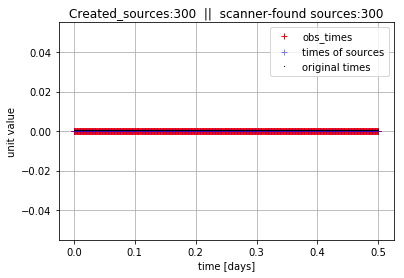

(None, <matplotlib.legend.Legend at 0x7fbb73f2b128>, None)

In [68]:
plt.figure()
 
plt.title('Created_sources:'+str(num_sources)+'  ||  scanner-found sources:'+str(len(calc_sources)))

plt.plot(obs_times,np.zeros(len(obs_times)), 'r+', label='obs_times')

plt.plot(times_for_source, np.zeros(len(times_for_source)), 'b+', label='times of sources', alpha=0.5)

sampled_times = np.linspace(t_init, t_end, num=500)
plt.plot(sampled_times, np.zeros(len(sampled_times)), 'k,', label='original times')

plt.xlabel('time [days]'), plt.ylabel('unit value') # , plt.ylim((-1e-6, 1e-6))

plt.grid(), plt.legend(), plt.show()

#bins: 24


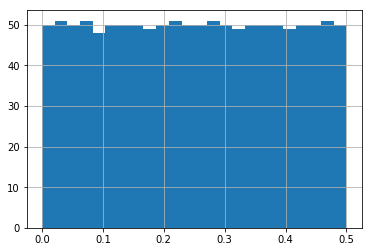

In [69]:
bins = int((t_end-t_init)/my_dt)
print('#bins:', bins)
plt.hist(obs_times, bins=bins, align='mid');
plt.grid();


In [70]:
def noise_calc_sources(s):
    noise = 0.02 / 10
    s.s_params[0] += noise
    s.s_params[1] += noise
    s.s_params[2] += -s.s_params[2]/100
    s.s_params[3] += s.s_params[3]*0.01
    s.s_params[4] += s.s_params[4]*0.01

In [71]:
print('Updating only sources:')
Solver = Agis(gaia, calc_sources, sources, updating='scanned source', double_telescope=double_telescope)

Updating only sources:


In [72]:
Solver.error_function()

0.0

In [73]:
# Solver.reset_iterations()
#Solver.iterate(1)

# *Update Attitude*

In [74]:
if len(sources) != len(calc_sources):
    raise ValueError('there must be the same number of real and calc sources')

In [75]:
print('Updating attitude')
spline_degree = 3
Solver = Agis(sat=gaia, calc_sources=calc_sources, real_sources=sources, updating='attitude',
              double_telescope=double_telescope,
              attitude_splines=[gaia.s_w, gaia.s_x, gaia.s_y, gaia.s_z], 
              spline_degree=spline_degree,
              attitude_regularisation_factor=1e-2)

Updating attitude


In [76]:
# Ignore this cell if you don't want to modify the initial attitude
# Can be used to check that when recreating the splines in the solver we (almost) do not create additional errors
my_times = np.array(obs_times)
# Solver.actualise_splines()
print('Error before Noise: ', Solver.error_function())
# print('Errors after noise of attitude (not representatif):', error_between_func_attitudes(my_times, gaia.func_attitude, Solver.get_attitude))
c_noise = Solver.att_coeffs * np.random.rand(Solver.att_coeffs.shape[0], Solver.att_coeffs.shape[1]) * 1e-6
print('c_noise shape: ', c_noise.shape)
last_coef = 4
#Solver.att_coeffs[:last_coef] = Solver.att_coeffs[:last_coef] + c_noise[:last_coef]
Solver.actualise_splines()
#Solver.set_splines_basis()
print('Error after Noise: ', Solver.error_function())
# print('Errors after noise of attitude (not representatif):', error_between_func_attitudes(my_times, gaia.func_attitude, Solver.get_attitude))

Error before Noise:  0.0
c_noise shape:  (4, 25)
Error after Noise:  0.0


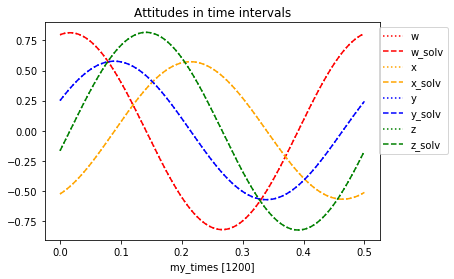

In [77]:
compare_attitudes(gaia, Solver, obs_times)

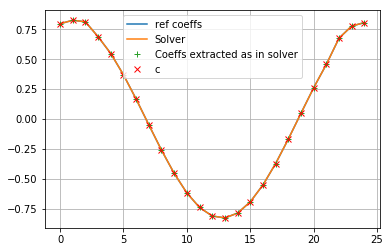

(None, <matplotlib.legend.Legend at 0x7fbb7421e518>, None)

In [78]:
to_fit = gaia.s_w
c, t, s = extract_coeffs_knots_from_splines([gaia.s_w, gaia.s_x, gaia.s_y, gaia.s_z], k=3)
a_ref = to_fit.get_coeffs()
plt.plot(a_ref, label='ref coeffs')
plt.plot(Solver.att_coeffs[0], label='Solver')
plt.plot(c[0], '+', label='Coeffs extracted as in solver')
plt.plot(Solver.c[0], 'rx', label='c')
plt.grid(), plt.legend(), plt.show()

**Plot matrices:**

In [79]:
if (Solver.att_knots.shape[0] - Solver.att_coeffs.shape[1]) != 4:
    raise ValueError('there should be 4 coeffs less than the number of knots')

In [80]:
N_aa = Solver.compute_attitude_LHS()

N_aa_dim: 25


In [81]:
N_aa_w = N_aa[0::4, 0::4]
N_aa_x = N_aa[1::4, 1::4]
N_aa_y = N_aa[2::4, 2::4]
N_aa_z = N_aa[3::4, 3::4]
N_aa_list = [N_aa_w, N_aa_x, N_aa_y, N_aa_z]
print('N_aa_w.shape', N_aa_w.shape)
print('N_aa_z.shape', N_aa_z.shape)

N_aa_w.shape (25, 25)
N_aa_z.shape (25, 25)


In [82]:
obs_times

[1.1606912820027583e-09,
 1.23259574493153e-05,
 0.0007273669186627928,
 0.0008966548310876847,
 0.0016354896425715948,
 0.0017981059158709632,
 0.002522109631747523,
 0.0025268063538113838,
 0.003258717898706002,
 0.0034232494751946984,
 0.004151656359606239,
 0.004320029976371183,
 0.005050504007977302,
 0.005050506312514223,
 0.005776387365501626,
 0.005946459780790585,
 0.006684149393699714,
 0.006847824808028021,
 0.0075727840697116895,
 0.0075764977553112334,
 0.008308091192754385,
 0.0084733511733366,
 0.009202167521316635,
 0.009371834932474513,
 0.01010100919397209,
 0.010101011443512286,
 0.010827194542357263,
 0.010998386279691016,
 0.01173401701028662,
 0.01189899979040648,
 0.012624899334566732,
 0.01262739177789528,
 0.013357937031578644,
 0.013524706950932039,
 0.014253138293010368,
 0.014424387670969261,
 0.015151514394782344,
 0.01515151655265282,
 0.015878155139510998,
 0.01605072646438155,
 0.016783218720275397,
 0.016950364009176183,
 0.017676849436979485,
 0.017677

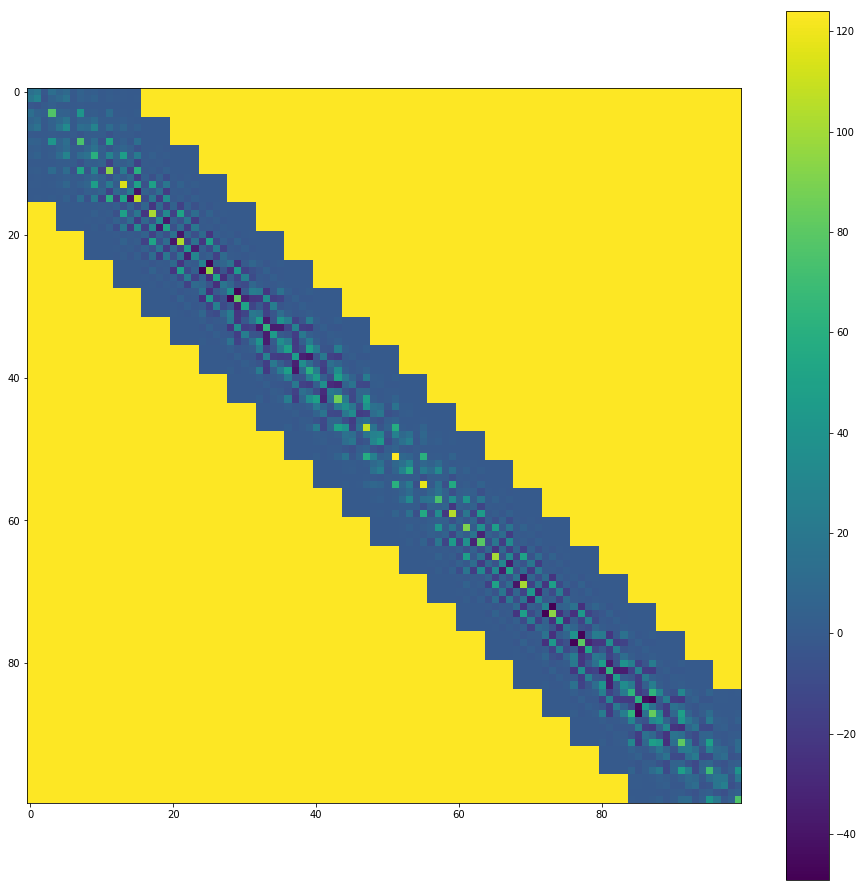

In [83]:
A=N_aa
plt.figure(figsize=(16,16))
threshold = 0
A[np.where(A==threshold)] = A.max()
plt.imshow(A, vmin=None, vmax=None)
plt.colorbar()
#fig.colorbar(plot1, ax=plt)

Text(0.5, 0.98, 'Matrix visualization')

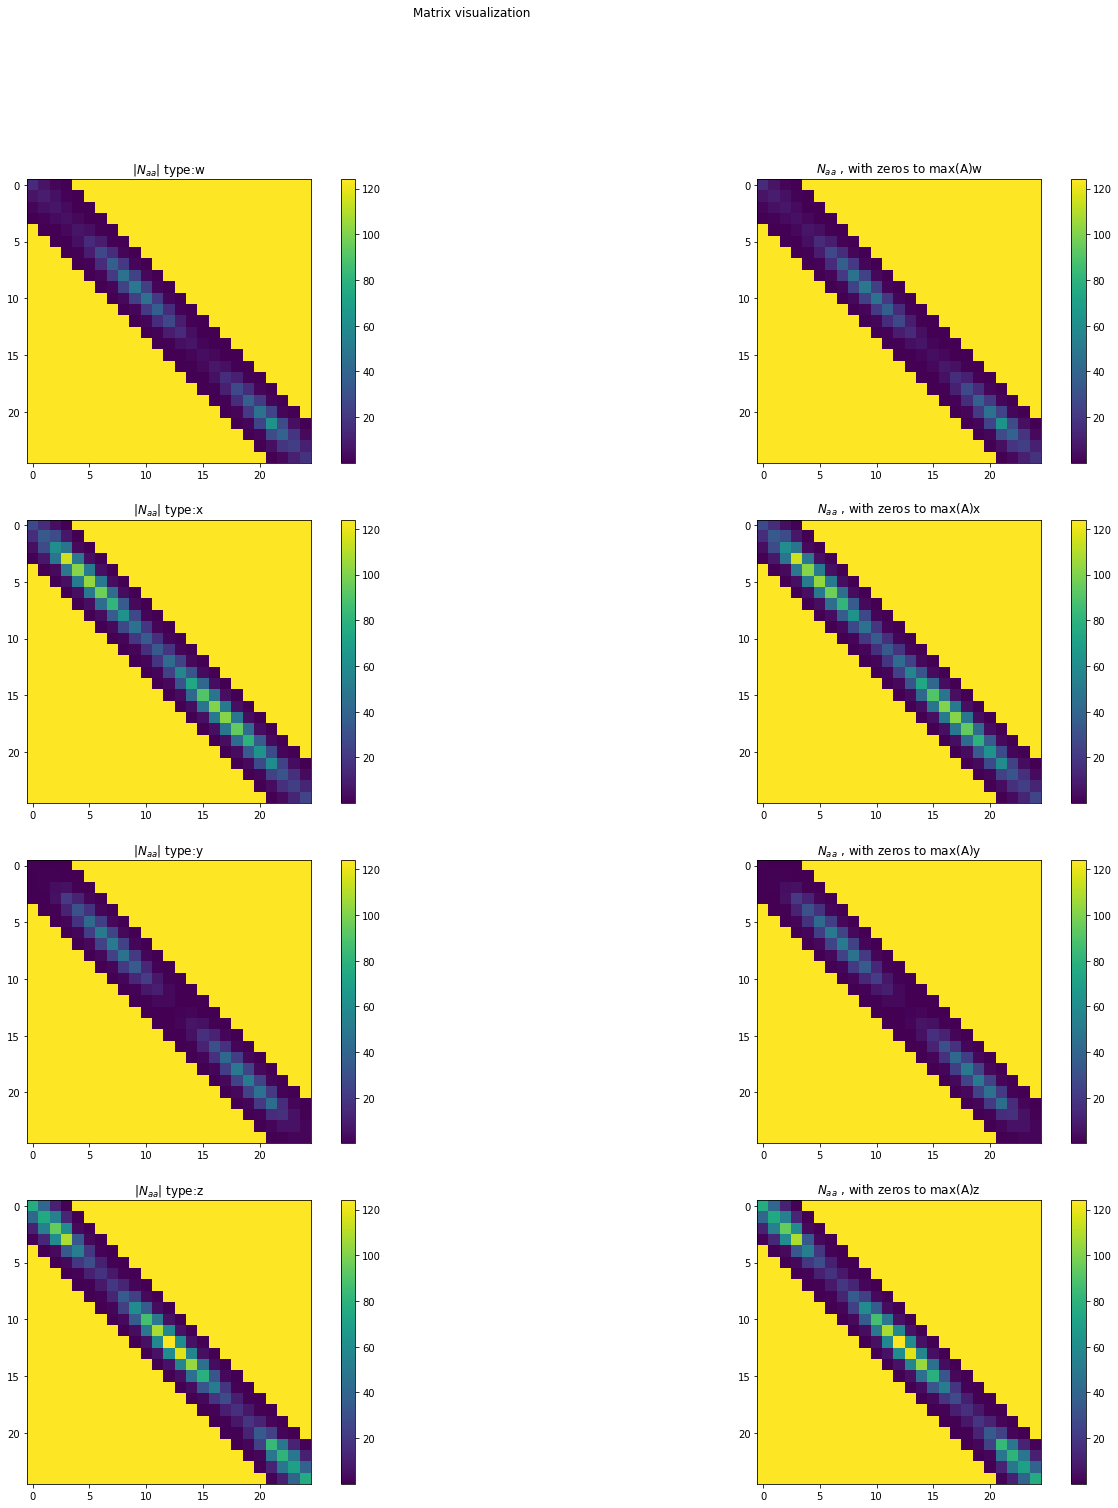

In [84]:
fig, axs = plt.subplots(4, 2, figsize=(24, 24))

type_list = ['w', 'x', 'y', 'z']
for i in range(4):
    A = N_aa_list[i].copy()
    plot1 = axs[i, 0].imshow(np.abs(A), vmin=None, vmax=None)
    axs[i, 0].set_title("$|N_{aa}|$ type:"+type_list[i])
    
    threshold = 0
    A[np.where(A==threshold)] = A.max()
    plot2 = axs[i, 1].imshow(A, vmin=None, vmax=None)
    axs[i, 1].set_title("$N_{aa}$ , with zeros to max(A)"+type_list[i])

    fig.colorbar(plot1, ax=axs[i, 0])
    fig.colorbar(plot2, ax=axs[i, 1])
    
fig.suptitle('Matrix visualization')
# plt.show()

In [85]:
Solver.att_coeffs.shape

(4, 25)

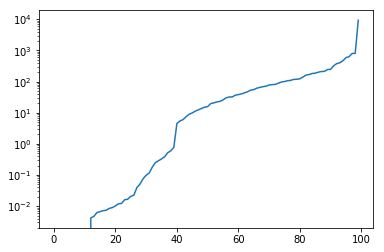

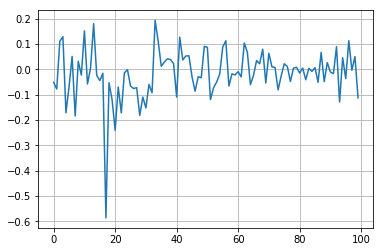

In [86]:
eig_vals, eig_vecs = np.linalg.eigh(N_aa)
plt.plot(eig_vals, label=type_list[i])
    
plt.yscale('log')
#plt.xlim(0,5)
plt.show()


plt.plot(eig_vecs[0])
#plt.xlim(100,110)
plt.grid()
plt.show()

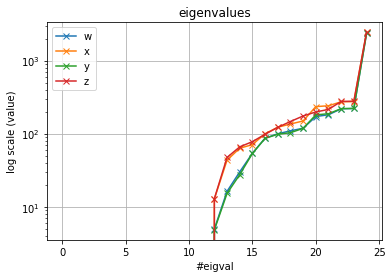

In [89]:
for i, Naa in enumerate(N_aa_list):
    eig_vals, eig_vecs = np.linalg.eigh(Naa)
    plt.plot(eig_vals, label=type_list[i],marker='x')
    if not helpers.check_symmetry(Naa):
        raise ValueError('Matrix not symmetric')
    # print('Condition number: ', np.linalg.cond(Naa))
    # print('Condition number (eig_max/eig_min): ', np.abs(eig_vals.max())/np.abs(eig_vals.min()))
    # print('Rank: ', np.linalg.matrix_rank(Naa, hermitian=True))
    # print('det(N_aa):', np.linalg.det(Naa),'\n')
plt.yscale('log'), plt.legend(), plt.grid()
plt.title('eigenvalues'), plt.ylabel('log scale (value)'), plt.xlabel('#eigval')
# plt.xlim((0,5))

plt.show()

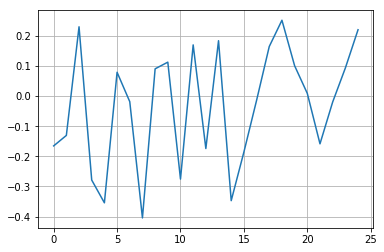

In [90]:
eig_vals, eig_vecs = np.linalg.eigh(N_aa_list[2])
plt.plot(eig_vecs[0])
plt.grid()

# **See iterations**

***** Iteration: 1 *****
N_aa_dim: 25
attitude error: 0.02053274730987053
Error after iteration: 7.35289652363534e-07


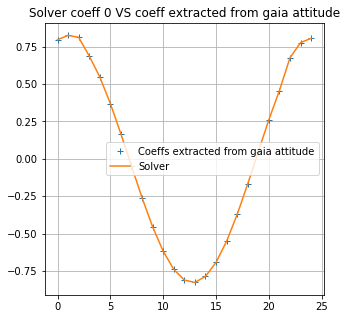

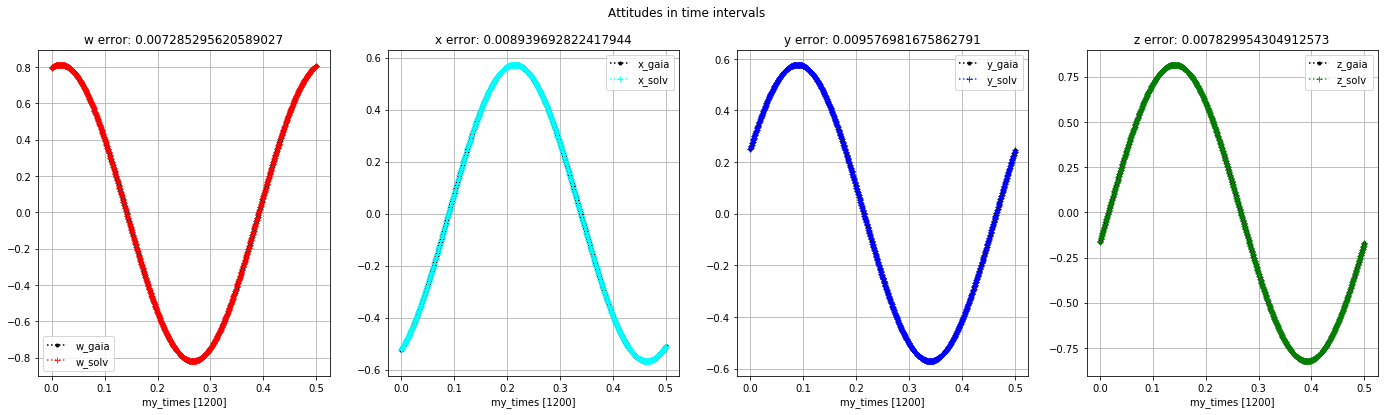

MAGNITUDE: 1.0000322828409929


In [91]:
Solver.verbose=False
# Solver.reset_iterations()
Solver.iterate(1)

plt.figure(figsize=(5,5))
c, t, s = extract_coeffs_knots_from_splines([gaia.s_w, gaia.s_x, gaia.s_y, gaia.s_z], k=3)
plt.plot(c[0], '+', label='Coeffs extracted from gaia attitude')
plt.plot(Solver.att_coeffs[0], label='Solver')
plt.title('Solver coeff 0 VS coeff extracted from gaia attitude')
plt.grid(), plt.legend(), plt.show()
fig2 = multi_compare_attitudes(gaia, Solver, obs_times)
print('MAGNITUDE:', Solver.get_attitude(0.005, unit=False).magnitude)
fig2.savefig('figures/tmp/lala.png')

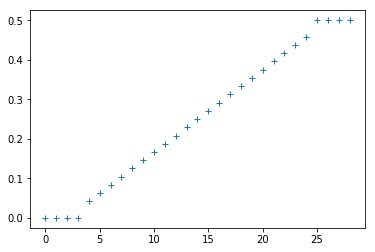

In [92]:
plt.plot(Solver.att_knots, '+')
plt.show()

In [81]:
Solver.iterate(100)

***** Iteration: 3 *****
N_aa_dim: 121


KeyboardInterrupt: 

In [ ]:
fig2 = multi_compare_attitudes(gaia, Solver, obs_times)


In [61]:
B = A.copy()
A = Solver.compute_attitude_LHS()
print((B-A).sum())

N_aa_dim: 25
-2793.8023511538568


In [62]:
hi = h
h = Solver.compute_attitude_RHS()
print((hi-h).sum())

-9.217095069543289e-12
